# Canonical CNN Architecture

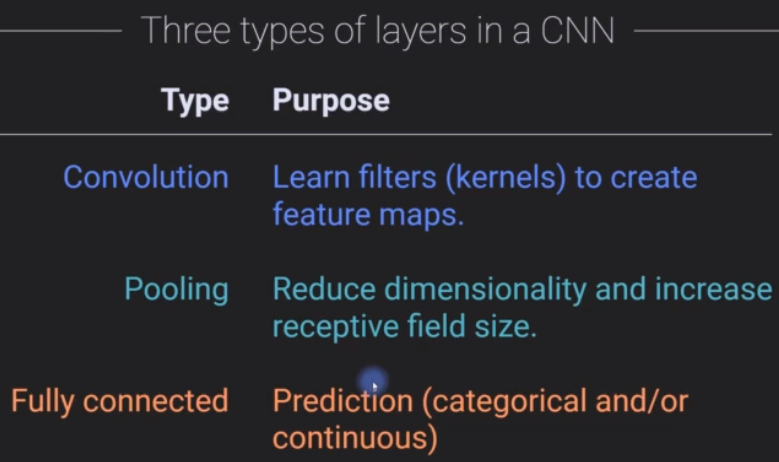

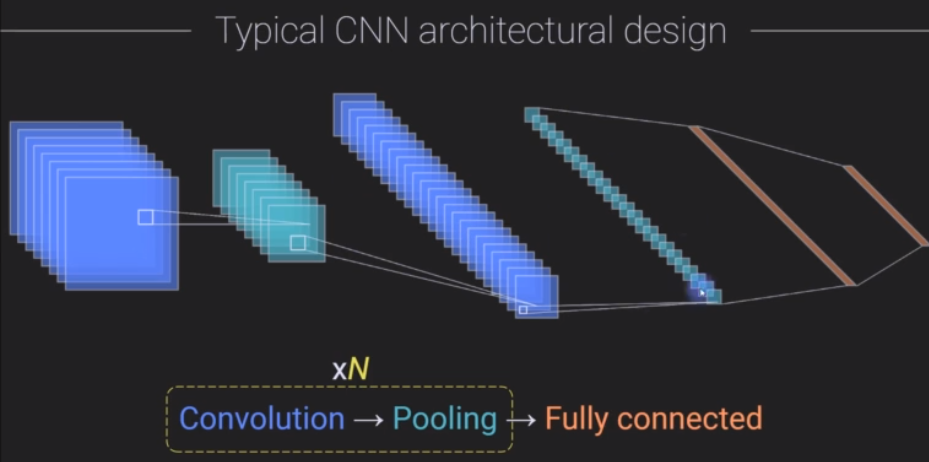

With increasing depth:
- Image resolution (number of pixels) decreases
- Representation resolution (number of filters) increases
- Layers are getting smaller but wider

# CNN to Classify MNIST

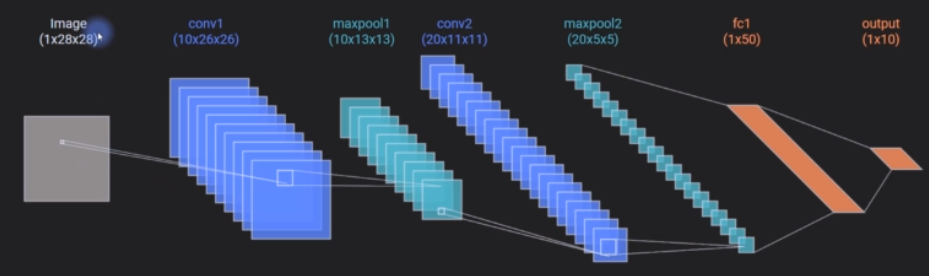

From final maxpool (20x5x5 = 500), we go to fc1 (1x50 = 50) 

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# importing data

# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract only the first 8
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# reshaping data to 2D
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
# above format - (no. of img, no. of channels, height. width)

print(dataNorm.shape)
print(labels.shape)

# convert to torch tensor format
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

# Step 4: translate into dataloader objects
batchsize    = 32
trainLoader = DataLoader(train_ds,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_ds,batch_size=test_ds.tensors[0].shape[0])

(20000, 1, 28, 28)
(20000,)


In [3]:
trainLoader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

### Creating CNN

```nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)```

first param is number of img at once.  
second param is nmber of op channels (kernels) output after convolution operation.

__Second param of first conv layer should match first param of following conv layer__  
which is why : ```nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)```

After convolution: final op size is 20x5x5

```
# computing no of units in FC layer (op of conv2)
            expectSize = np.floor((5+2*1-5)/1) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)
```

```expectSize = np.floor((5+2*1-5)/1) + 1``` gives number of units after conv  
```expectSize = 20*int(expectSize**2)``` is because we have square images, and that's the amount of units required, 20x is required as there are 20 channels after the layer.

```F.max_pool2d(self.conv2(x), 2)``` - 2 defines the number of pixels or the window size we are maxpooling over.

```
# reshaping for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
```
reshaping x to linear form

In [4]:
def createMNISTnet(printtoggle=False):
    class MNISTNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            # conv layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            # size = np.floor((28+2*1-5)/1)+1 = 26/2 = 13 (/2 for maxpool) - op of this layer is 26x26, op of maxpool is 13x13
            
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            # size = np.floor((13+2*1-5)/1)+1 = 11/2 = 5 (/2 for maxpool) - op of this layer is 11x11, op of maxpool is 5x5
            
            # computing no of units in FC layer (op of conv2)
            expectSize = np.floor((5+2*0-1)/1) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)
            
            # fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)
            
            self.op = nn.Linear(50, 10) # op layer
            
            # toggle for printing tensors during forward prop
            self.print = printtoggle
            
        def forward(self, x):
            print(f'Input: {x.shape}') if self.print else None
            
            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None
            
            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None
            
            # reshaping for linear layer
            nUnits = x.shape.numel()/x.shape[0] # nUnits is 500 at this point - 20x5x5
            x = x.view(-1, int(nUnits))
            
#             print('printing x.shape.numel():', x.shape.numel())
#             print('printing x.shape[0]:', x.shape[0])
#             print('printing x.view(-1, int(nUnits)):', x.view(-1, int(nUnits)))
            
            if self.print: print(f'Vectorize: {x.shape}')
            
            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.op(x)
            if self.print: print(f'Layer out: {x.shape}')
            
            return x
        
    net = MNISTNet(printtoggle)

    lossfn = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(net.parameters(), lr=0.001)
        
    return net, lossfn, optim

In [5]:
# testing model

net, lossfn, optim = createMNISTnet(True)

x, y = next(iter(trainLoader))
yH = net(x)

# checking size of model op and target variable
print('After run:')
print(yH.shape)
print(y.shape)

loss = lossfn(yH, y)
print('loss:', loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
After run:
torch.Size([32, 10])
torch.Size([32])
loss: tensor(2.3155, grad_fn=<NllLossBackward0>)


In [6]:
summary(net, (1,28,28)) # counting total number of parameters in model

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [11]:
# function to train model

# a function that trains the model

def trainModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = createMNISTnet()

    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

        # end epochs

    # function output
    return net, losses, trainAcc, testAcc


In [12]:
net, losses, trainAcc, testAcc = trainModel()

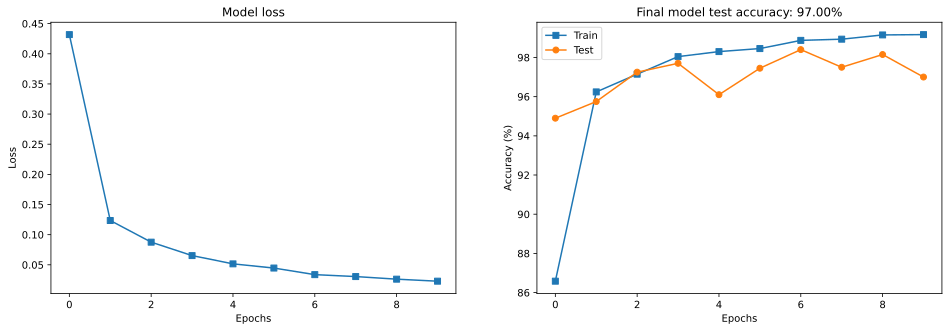

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# CNN on Shifted MNIST

In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# importing data

# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract only the first 8
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# reshaping data to 2D
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
# above format - (no. of img, no. of channels, height. width)

print(dataNorm.shape)
print(labels.shape)

# convert to torch tensor format
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

# Step 4: translate into dataloader objects
batchsize    = 32
trainLoader = DataLoader(train_ds,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_ds,batch_size=test_ds.tensors[0].shape[0])

(20000, 1, 28, 28)
(20000,)


In [21]:
# shifting images in train set

for i in range(trainLoader.dataset.tensors[0].shape[0]):
    img = trainLoader.dataset.tensors[0][i,:,:]
    
    # reshape and roll by 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll(img, randroll, dims=1)
    
    # revectorize and put back
    trainLoader.dataset.tensors[0][i,:,:] = img

In [22]:
# do the same for test data

for i in range(testLoader.dataset.tensors[0].shape[0]):
    img = testLoader.dataset.tensors[0][i,:,:]
    
    # reshape and roll by 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll(img, randroll, dims=1)
    
    # revectorize and put back
    testLoader.dataset.tensors[0][i,:,:] = img

In [17]:
def createMNISTnet(printtoggle=False):
    class MNISTNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            # conv layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            # size = np.floor((28+2*1-5)/1)+1 = 26/2 = 13 (/2 for maxpool) - op of this layer is 26x26, op of maxpool is 13x13
            
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            # size = np.floor((13+2*1-5)/1)+1 = 11/2 = 5 (/2 for maxpool) - op of this layer is 11x11, op of maxpool is 5x5
            
            # computing no of units in FC layer (op of conv2)
            expectSize = np.floor((5+2*0-1)/1) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)
            
            # fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)
            
            self.op = nn.Linear(50, 10) # op layer
            
            # toggle for printing tensors during forward prop
            self.print = printtoggle
            
        def forward(self, x):
            print(f'Input: {x.shape}') if self.print else None
            
            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None
            
            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None
            
            # reshaping for linear layer
            nUnits = x.shape.numel()/x.shape[0] # nUnits is 500 at this point - 20x5x5
            x = x.view(-1, int(nUnits))
            
#             print('printing x.shape.numel():', x.shape.numel())
#             print('printing x.shape[0]:', x.shape[0])
#             print('printing x.view(-1, int(nUnits)):', x.view(-1, int(nUnits)))
            
            if self.print: print(f'Vectorize: {x.shape}')
            
            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.op(x)
            if self.print: print(f'Layer out: {x.shape}')
            
            return x
        
    net = MNISTNet(printtoggle)

    lossfn = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(net.parameters(), lr=0.001)
        
    return net, lossfn, optim

In [18]:
# function to train model

# a function that trains the model

def trainModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = createMNISTnet()

    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

        # end epochs

    # function output
    return net, losses, trainAcc, testAcc


In [23]:
net, losses, trainAcc, testAcc = trainModel()

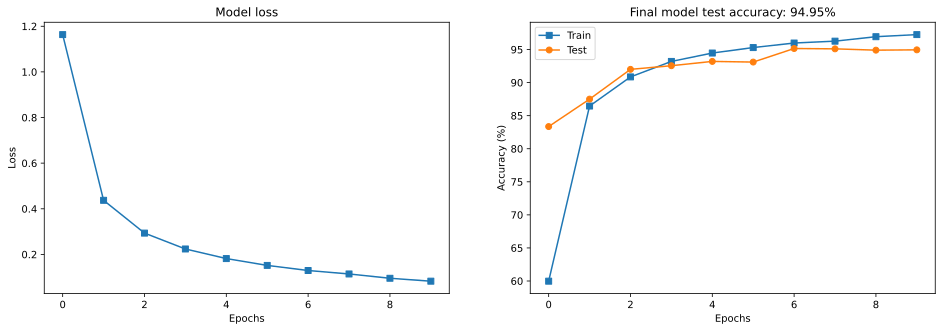

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Classify Gaussian Blurs

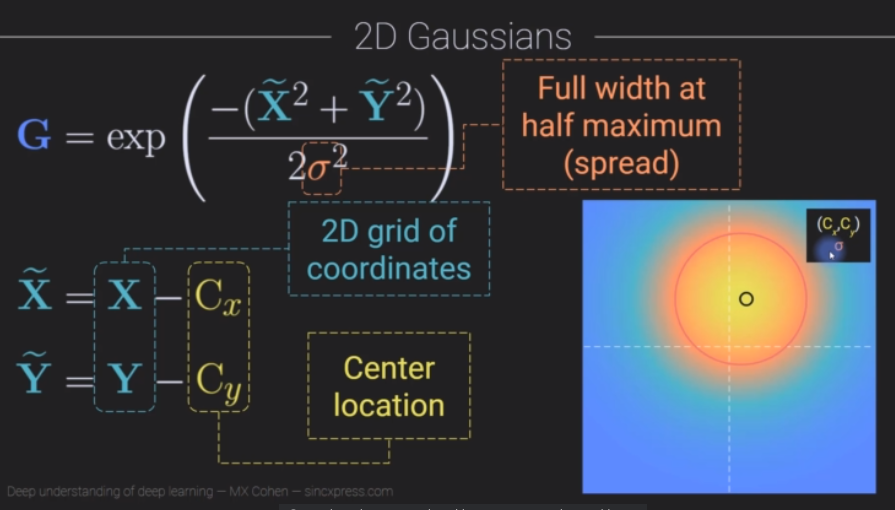

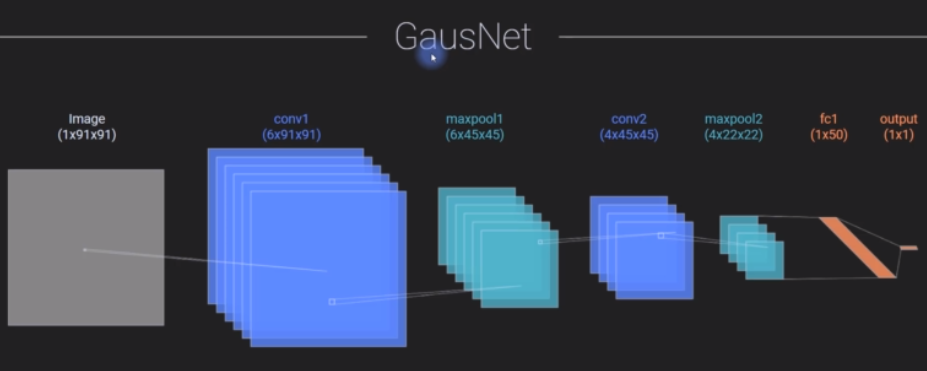

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


### Creating Gaussian blurs

In [5]:
npc = 1000 # number of points per class
imgSize = 91 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units)
widths = [1.8, 2.4]

# initializing tensors containing images and labels
imgs = torch.zeros(2*npc, 1, imgSize, imgSize)
labels = torch.zeros(2*npc)

for i in range(2*npc):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i] = i%2
    
labels = labels[:, None]

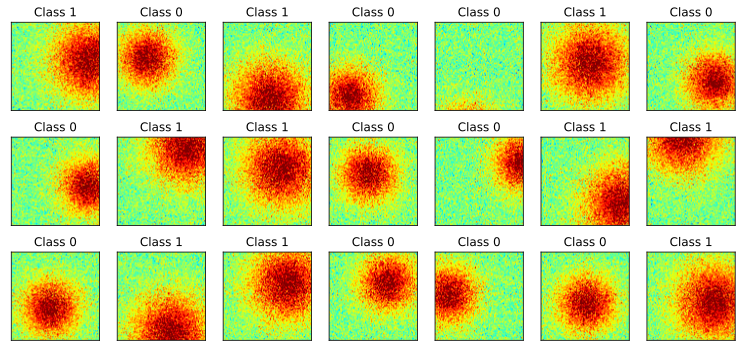

In [7]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*npc)
    G = np.squeeze( imgs[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=.2)

# Step 3: convert into PyTorch Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

# Step 4: translate into dataloader objects
batchsize    = 32
trainLoader = DataLoader(train_ds,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_ds,batch_size=test_ds.tensors[0].shape[0])

In [31]:
# checking size
print(trainLoader.dataset.tensors[0].shape)
print(trainLoader.dataset.tensors[1].shape)

torch.Size([1600, 1, 91, 91])
torch.Size([1600, 1])


### Creating DL model

In [32]:
def makeNet():
    class gaussNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.layers = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1), # op size = (91+2*1-3)/1 + 1 = 91
                nn.ReLU(),
                nn.AvgPool2d(2,2), # op size = 91/2 = 45
                
                nn.Conv2d(6,4,3,padding=1), # op size = (45+2*1-3)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2,2), # op size = 45/2 = 22
                
                nn.Flatten(),  # vectorizing conv op 
                nn.Linear(22*22*4,  50), # op size = 50
                nn.Linear(50, 1) # op size = 1
            )
        
        def forward(self, x):
            return self.layers(x)
        
    
    net = gaussNet()
    
    lossfn = nn.BCEWithLogitsLoss()
    
    optim = torch.optim.Adam(net.parameters(), lr = 0.001)
    
    return net, lossfn, optim

In [33]:
# testing model

# testing model

net, lossfn, optim = makeNet()

x, y = next(iter(trainLoader))
yH = net(x)

# checking size of model op and target variable
print('After run:')
print(yH.shape)
print(y.shape)

loss = lossfn(yH, y)
print('loss:', loss)

After run:
torch.Size([32, 1])
torch.Size([32, 1])
loss: tensor(0.6940, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [34]:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [35]:
# function to train model

# a function that trains the model

def trainModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = makeNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)


    # loop over epochs
    for i in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(( (yHat>0) ==y).float()).item())
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[i] = 100*np.mean(batchAcc)
        trainLoss[i] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfn(yHat, y)

        # compare the following really long line of code to the training accuracy lines
        testAcc[i] = 100*torch.mean(( (yHat>0) ==y).float()).item()
        testLoss[i] = loss.item()

        # end epochs

    # function output
    return net, trainLoss, testLoss, trainAcc, testAcc

In [36]:
net, trainLoss, testLoss, trainAcc, testAcc = trainModel()

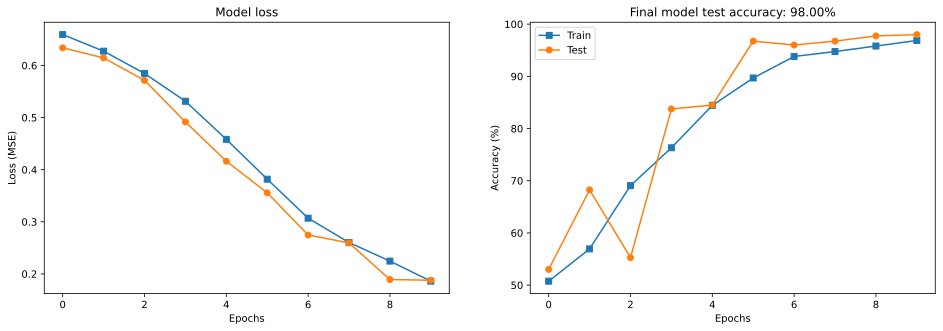

In [37]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

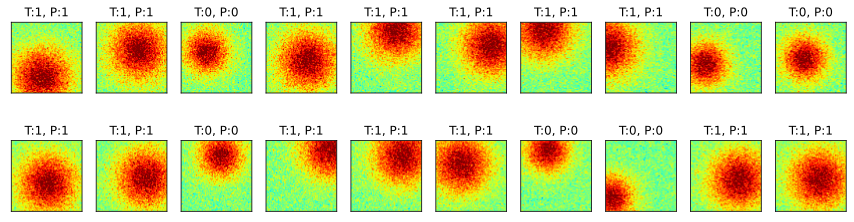

In [38]:
# visualize some images

X,y = next(iter(testLoader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [39]:
# looking at filters

print(net)

l1W = net.layers[0].weight
l3W = net.layers[3].weight

print(l1W.shape)
print(l3W.shape)

gaussNet(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


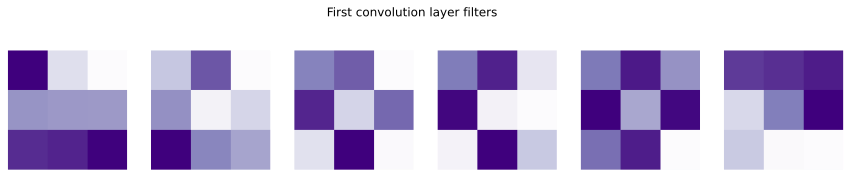

In [40]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
    ax.imshow( torch.squeeze(l1W[i,:,:,:]).detach() ,cmap='Purples')
    ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

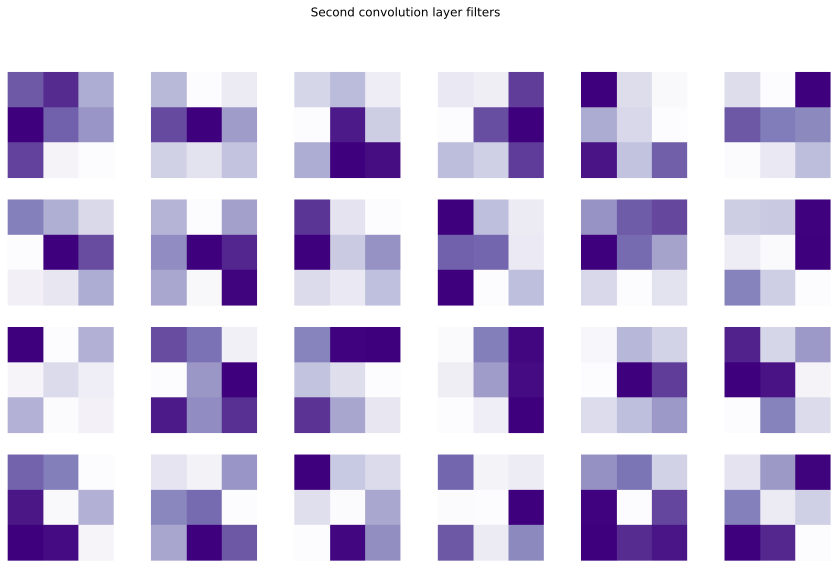

In [41]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
    idx = np.unravel_index(i,(4,6))
    axs[idx].imshow( torch.squeeze(l3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
    axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()